In [313]:
from numpy import *
from pandas import read_csv
from matplotlib.pyplot import *
n = 1.00866491588 #u
p = 1.007276466621 #u
uc2 = 931.49410242 # MeV

In [314]:
Data = read_csv("all_nuclei.csv")
toremove = []
for i in Data.index:
    if(Data["N"][i]> 3*Data["Z"][i]):
        toremove.append(i)
Data = Data.drop(toremove)
N = Data["N"]
Z = Data["Z"]
A = N+Z
M = Data["AtomicMass"] # in 'u'
BE = (N*n+Z*p-M)*uc2 # in MeV
Data["BE"] = BE
Data["BE/A"] = BE/A
Data.columns

Index(['Z', 'N', 'AtomicMass', 'energy_double', 'spin_string', 'parity', 'BE',
       'BE/A'],
      dtype='object')

In [315]:
Del0 = 1 #MeV
aPt  = A**(-1/2)
for i in Data.index:
    if A[i]%2 == 0:
        aPt[i] = 0
    elif Z[i]%2==1:
        aPt[i] = -aPt[i]
aVt = A
aSt = -A**(2/3)
aCt = -Z*(Z-1)*A**(-1/3)
aAt = -((N-Z)**2)/A
X = array([aVt,aSt,aCt,aAt,aPt]).T
pseudoinverse = linalg.inv(X.T @ X) @ X.T
coeff = dot(pseudoinverse,BE)
aV,aS,aC,aA,aP = coeff
print(coeff)

[15.57075537 18.21307623  0.71894211 22.43669662  0.07231096]


/tmp/ipykernel_142089/602428694.py:4: RuntimeWarning: divide by zero encountered in power
  Z = (4*aA+aC*A**(-1/3))/(8*aA/A + 2*aC*A**(-1/3))
/tmp/ipykernel_142089/602428694.py:4: RuntimeWarning: divide by zero encountered in divide
  Z = (4*aA+aC*A**(-1/3))/(8*aA/A + 2*aC*A**(-1/3))
/tmp/ipykernel_142089/602428694.py:4: RuntimeWarning: invalid value encountered in divide
  Z = (4*aA+aC*A**(-1/3))/(8*aA/A + 2*aC*A**(-1/3))


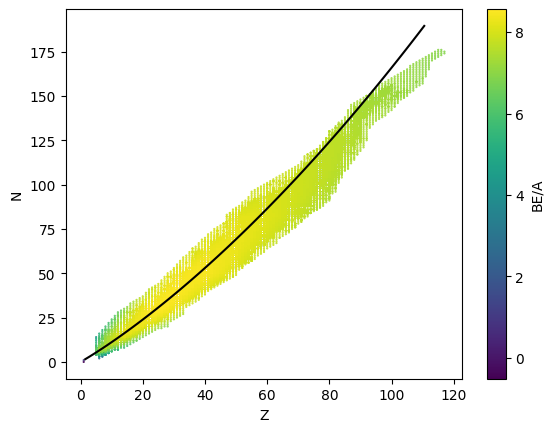

In [316]:
Data = Data.drop(Data.index[:300])
Data.plot.scatter("Z","N",color ="BE/A",s=0.3,colormap='viridis')
A = linspace(0,300,100)
Z = (4*aA+aC*A**(-1/3))/(8*aA/A + 2*aC*A**(-1/3))
N = A-Z
plot(Z,N,'black')
show()